# Open University Learning Analytics

### Using statsmodels

#### Data Source: https://www.open.ac.uk/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import os

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from plotnine import *

%matplotlib inline

In [3]:
#os.listdir('datasets')

In [4]:
ou = pd.read_csv('datasets/ou.csv')
ou.head(3)

,activity_external_site,activity_forum,activity_glossary,activity_other,activity_questionnaire,activity_quiz,activity_wiki,age_band,course_code,course_start,...,date_registration,disability,final_result,gender,highest_education,imd_band,prev_attempts,region,student_id,studied_credits
0,2.0,11.0,NaN,42,NaN,NaN,NaN,55+,A,October,...,-159,False,Pass,M,HE Qualification,90-100%,0,East Anglia,11391,240
1,5.0,15.0,NaN,64,NaN,NaN,NaN,35-55,A,October,...,-53,False,Pass,F,HE Qualification,20-30%,0,Scotland,28400,60
2,2.0,13.0,1.0,66,NaN,NaN,NaN,35-55,A,October,...,-52,False,Pass,F,A Level or Equivalent,50-60%,0,South East,31604,60


In [5]:
ou.shape

(21115, 22)

In [6]:
ou['final_result'].unique()

array(['Pass', 'Fail', 'Distinction'], dtype=object)

- Our target is final_result pass, fail, distinction. 
- In order to use logistic regression model, we need to normalise the data first.

In [7]:
# Create new column called 'passed', in order to have binary target variable
ou['passed'] = (ou['final_result'] != 'Fail').astype(int)
ou.shape

(21115, 23)

We can see new column has been added. 'Passed' is now our new target variable which is binary

In [8]:
# check new column
ou['passed'].unique()

array([1, 0], dtype=int64)

In [9]:
# Create new column called course_id by concatenate course_code, course_year and course_start
ou['course_id'] = ou['course_code'] + '-' + ou['course_year'].astype(str) + '-' + ou['course_start'].str[:3]

#check new column
ou['course_id'].head()

0    A-2013-Oct
1    A-2013-Oct
2    A-2013-Oct
3    A-2013-Oct
4    A-2013-Oct
Name: course_id, dtype: object

In [10]:

ou.shape

(21115, 24)

# EDA - Exploratory Data Analysis

In [11]:
ou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21115 entries, 0 to 21114
Data columns (total 24 columns):
activity_external_site    18118 non-null float64
activity_forum            20034 non-null float64
activity_glossary         5243 non-null float64
activity_other            21115 non-null int64
activity_questionnaire    4021 non-null float64
activity_quiz             19530 non-null float64
activity_wiki             8711 non-null float64
age_band                  21115 non-null object
course_code               21115 non-null object
course_start              21115 non-null object
coursework_avg            18941 non-null float64
course_year               21115 non-null int64
date_registration         21115 non-null int64
disability                21115 non-null bool
final_result              21115 non-null object
gender                    21115 non-null object
highest_education         21115 non-null object
imd_band                  20257 non-null object
prev_attempts             21

In [12]:
ou.isnull().sum()

activity_external_site     2997
activity_forum             1081
activity_glossary         15872
activity_other                0
activity_questionnaire    17094
activity_quiz              1585
activity_wiki             12404
age_band                      0
course_code                   0
course_start                  0
coursework_avg             2174
course_year                   0
date_registration             0
disability                    0
final_result                  0
gender                        0
highest_education             0
imd_band                    858
prev_attempts                 0
region                        0
student_id                    0
studied_credits               0
passed                        0
course_id                     0
dtype: int64

### Working with missing/ null values

In [13]:
ou.isnull().sum()

activity_external_site     2997
activity_forum             1081
activity_glossary         15872
activity_other                0
activity_questionnaire    17094
activity_quiz              1585
activity_wiki             12404
age_band                      0
course_code                   0
course_start                  0
coursework_avg             2174
course_year                   0
date_registration             0
disability                    0
final_result                  0
gender                        0
highest_education             0
imd_band                    858
prev_attempts                 0
region                        0
student_id                    0
studied_credits               0
passed                        0
course_id                     0
dtype: int64

In [14]:
ou.dtypes

activity_external_site    float64
activity_forum            float64
activity_glossary         float64
activity_other              int64
activity_questionnaire    float64
activity_quiz             float64
activity_wiki             float64
age_band                   object
course_code                object
course_start               object
coursework_avg            float64
course_year                 int64
date_registration           int64
disability                   bool
final_result               object
gender                     object
highest_education          object
imd_band                   object
prev_attempts               int64
region                     object
student_id                  int64
studied_credits             int64
passed                      int32
course_id                  object
dtype: object

In [15]:
activity_cols = [x for x in ou.columns if x.startswith('activity_')]
activity_cols

['activity_external_site',
 'activity_forum',
 'activity_glossary',
 'activity_other',
 'activity_questionnaire',
 'activity_quiz',
 'activity_wiki']

In [16]:
aggregates = ou.groupby('course_id')[activity_cols].agg([ 'median','max'])
#aggregates

aggregates.columns = ['_'.join(x) for x in aggregates.columns.values]

In [17]:
ou = pd.merge(ou, aggregates, on='course_id')

In [18]:
ou.shape

(21115, 38)

In [19]:
for col in activity_cols:
    ou[col] = (ou[col] - ou[col + '_median']) / ou[col + '_max']
    ou[col].fillna(0, inplace=True)
    ou[col + '_cat'] = (ou[col] > 0).astype(int)
    ou.drop(columns=[col + '_max', col + '_median'], inplace=True)

In [20]:
ou.head()

,activity_external_site,activity_forum,activity_glossary,activity_other,activity_questionnaire,activity_quiz,activity_wiki,age_band,course_code,course_start,...,studied_credits,passed,course_id,activity_external_site_cat,activity_forum_cat,activity_glossary_cat,activity_other_cat,activity_questionnaire_cat,activity_quiz_cat,activity_wiki_cat
0,0.000000,0.066667,0.0,-0.129630,0.0,0.0,0.0,55+,A,October,...,240,1,A-2013-Oct,0,1,0,0,0,0,0
1,0.176471,0.333333,0.0,0.074074,0.0,0.0,0.0,35-55,A,October,...,60,1,A-2013-Oct,1,1,0,1,0,0,0
2,0.000000,0.200000,0.0,0.092593,0.0,0.0,0.0,35-55,A,October,...,60,1,A-2013-Oct,0,1,0,1,0,0,0
3,0.058824,0.000000,0.5,-0.046296,0.0,0.0,0.0,0-35,A,October,...,60,1,A-2013-Oct,1,0,1,0,0,0,0
4,0.000000,0.333333,0.5,0.120370,0.0,0.0,0.0,35-55,A,October,...,60,1,A-2013-Oct,0,1,1,1,0,0,0


In [21]:
ou['passed'].value_counts()

1    15377
0     5738
Name: passed, dtype: int64

In [22]:
# Show the list of all categorical variables and count the values by its categories

for col in ou.select_dtypes(include='object').columns:
    print('=' * 10, col, '=' * 10)
    print(ou[col].value_counts())
    print()

========== age_band ==========
0-35     14595
35-55     6360
55+        160
Name: age_band, dtype: int64

========== course_code ==========
B    5182
F    5123
D    3797
C    2347
E    2055
G    2000
A     611
Name: course_code, dtype: int64

========== course_start ==========
October     13202
February     7913
Name: course_start, dtype: int64

========== final_result ==========
Pass           12353
Fail            5738
Distinction     3024
Name: final_result, dtype: int64

========== gender ==========
M    11480
F     9635
Name: gender, dtype: int64

========== highest_education ==========
A Level or Equivalent          9587
Lower Than A Level             7789
HE Qualification               3328
Post Graduate Qualification     237
No Formal quals                 174
Name: highest_education, dtype: int64

========== imd_band ==========
30-40%     2287
20-30%     2146
50-60%     2112
10-20      2100
40-50%     2075
70-80%     1990
60-70%     1945
80-90%     1905
0-10%      1887
90-100%

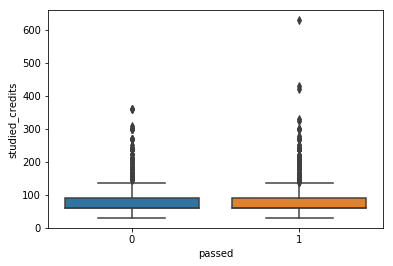

In [23]:
sns.boxplot(x='passed', y='studied_credits', data=ou)

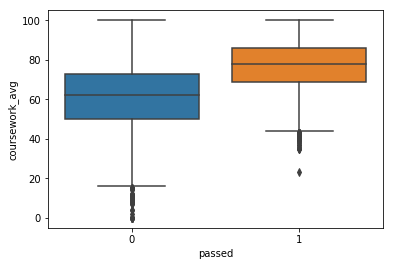

In [24]:
sns.boxplot(x='passed', y='coursework_avg', data=ou)

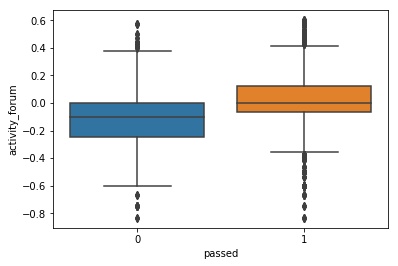

In [25]:
sns.boxplot(x='passed', y='activity_forum', data=ou)

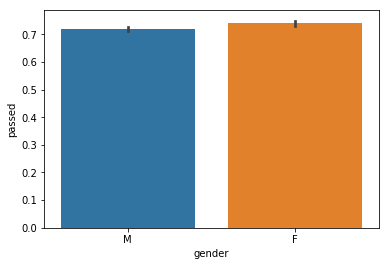

In [26]:
sns.barplot(x='gender', y='passed', data=ou)

In [27]:
ou.groupby('gender')['passed'].agg([ 'sum'])

,sum
gender,
F,7126
M,8251


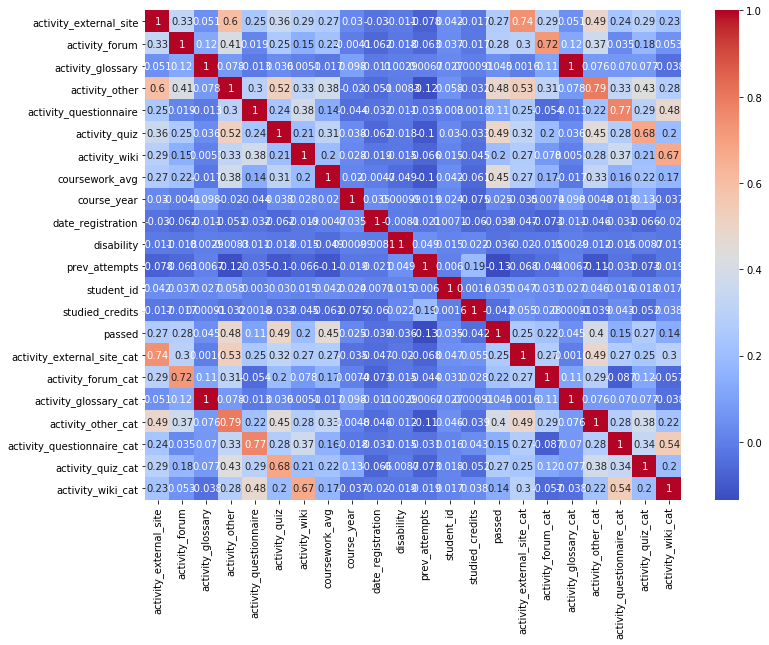

In [28]:
plt.figure(figsize=(12,9))
sns.heatmap(ou.corr(),cmap='coolwarm',annot=True)

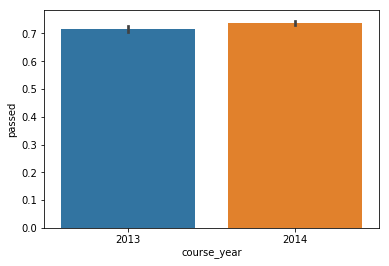

In [29]:
sns.barplot(x='course_year', y='passed', data=ou)

In [30]:
ou = ou.dropna(axis=1)

# Create a logistic model using statsmodel

In [31]:
model = smf.logit('passed ~ C(gender, Treatment("M")) + age_band + '
                  'activity_external_site_cat + activity_forum_cat + activity_glossary_cat +'
                  'activity_questionnaire_cat + activity_quiz_cat + activity_wiki_cat',
                  data=ou).fit()

Optimization terminated successfully.
         Current function value: 0.500741
         Iterations 7


In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 passed   No. Observations:                21115
Model:                          Logit   Df Residuals:                    21105
Method:                           MLE   Df Model:                            9
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                  0.1440
Time:                        14:39:30   Log-Likelihood:                -10573.
converged:                       True   LL-Null:                       -12352.
                                        LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.1301      0.027      4.885      0.000       0.078       0.182
C(gender, Treatment("M"))[T.F]     0.1249      0.034      3.665      0.000       0.058       0.192
age_band[T.35-55]                  0.0481      0.038      1.253      0.210      -0.027       0.123
age_band[T.55+]                    0.2383      0.228      1.046      0.296      -0.208       0.685
activity_external_site_cat         0.7721      0.043     18.000      0.000       0.688       0.856
activity_forum_cat                 1.1185      0.049     22.960      0.000       1.023       1.214
activity_glossary_cat              0.4321      0.205      2.105      0.035       0.030       0.835
activity_questionnaire_cat         0.9452      0.123      7.672      0.000       0.704       1.187
activity_quiz_cat                  1.6361      0.062     26.219      0.000       1.514       1.758
activity_wiki_cat                  0.6918      0.097      7.160      0.000       0.502       0.881
==================================================================================================
"""

In [33]:
np.exp(model.params)

Intercept                         1.138915
C(gender, Treatment("M"))[T.F]    1.133076
age_band[T.35-55]                 1.049295
age_band[T.55+]                   1.269083
activity_external_site_cat        2.164205
activity_forum_cat                3.060198
activity_glossary_cat             1.540535
activity_questionnaire_cat        2.573352
activity_quiz_cat                 5.135258
activity_wiki_cat                 1.997265
dtype: float64

In [34]:
np.exp(model.conf_int())

,0,1
Intercept,1.080996,1.199938
"C(gender, Treatment(""M""))[T.F]",1.059840,1.211373
age_band[T.35-55],0.973197,1.131343
age_band[T.55+],0.811875,1.983767
activity_external_site_cat,1.989706,2.354008
activity_forum_cat,2.781533,3.366781
activity_glossary_cat,1.030169,2.303746
activity_questionnaire_cat,2.021315,3.276156
activity_quiz_cat,4.544070,5.803360
activity_wiki_cat,1.652696,2.413673


In [35]:
model.pvalues

Intercept                          1.036348e-06
C(gender, Treatment("M"))[T.F]     2.476202e-04
age_band[T.35-55]                  2.103204e-01
age_band[T.55+]                    2.957705e-01
activity_external_site_cat         1.946600e-72
activity_forum_cat                1.165345e-116
activity_glossary_cat              3.531474e-02
activity_questionnaire_cat         1.688703e-14
activity_quiz_cat                 1.617722e-151
activity_wiki_cat                  8.078161e-13
dtype: float64

In [36]:
my_predictions = model.predict()

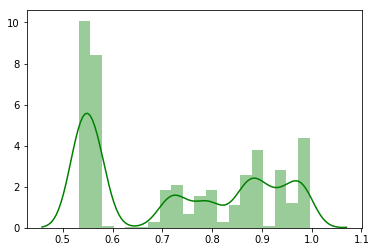

In [37]:
# Plot the distribution of predictions 
sns.distplot(my_predictions, color ='green')

In [38]:
pd.crosstab(my_predictions > 0.5, ou['final_result'])

final_result,Distinction,Fail,Pass
row_0,,,
True,3024,5738,12353


In [39]:
pd.crosstab(my_predictions > 0.5, ou['passed'])

passed,0,1
row_0,,
True,5738,15377


In [40]:
my_predictions

array([0.8156051 , 0.89967911, 0.80559085, ..., 0.87427097, 0.5634099 ,
       0.57520781])